### Wine & Cheese Pairing Recommender

#### Libraries

In [58]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests as rq
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

#### Checking Data

In [59]:
# Importing data from csv
wine_list = pd.read_csv('/Users/basakbuluttekin/Desktop/Final_Project/archive-2/winemag-data-130k-v2.csv')

In [60]:
# Checking the structure of dataset
wine_list.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [61]:
#Checking the details of columns
wine_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [62]:
# checking NaN values
wine_list.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

### Cleaning the data: dropping required columns and rows, filling or dropping the NaN values, dropping duplicates, adding new columns

In [63]:
# checking the inside of "unnamed: 0" column to decide drop it or not:
wine_list['check'] = wine_list['Unnamed: 0'] == wine_list.index
wine_list[wine_list['check']==False].value_counts()

Series([], Name: count, dtype: int64)

In [64]:
# index and "unnamed: 0" columns are the same so the column is needed to be dropped. 
wine_list.drop(columns={'check','Unnamed: 0'} , inplace =True)

In [65]:
# checking null values in country column to decide what to do:
wine_list['country'].value_counts()

country
US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14


In [66]:
# null values in country and province columns will be replaced as "Other" because the same raws are empty in both columns
# region_1 null values are replaced with "Unknown"
wine_list['country'].fillna("Other", inplace=True)
wine_list['province'].fillna("Other", inplace=True)
wine_list['region_1'].fillna('Unknown', inplace = True)

In [67]:
# there is only one null value in variety column and need to visiualize it to decide drop or not:
null_indices = wine_list[wine_list['variety'].isnull()].index
null_indices

Index([86909], dtype='int64')

In [68]:
# it is not possible to define which variety is this so this raw will be removed in below cell.
wine_list.loc[86909]

country                                                              Chile
description              A chalky, dusty mouthfeel nicely balances this...
designation                                                            NaN
points                                                                  88
price                                                                 17.0
province                                                      Maipo Valley
region_1                                                           Unknown
region_2                                                               NaN
taster_name                                                            NaN
taster_twitter_handle                                                  NaN
title                                          Carmen 1999  (Maipo Valley)
variety                                                                NaN
winery                                                              Carmen
Name: 86909, dtype: objec

In [69]:
#Dropping the null raw in variety
wine_list.dropna(subset = ['variety'], inplace=True)

In [70]:
# Checking duplicates in title column, each one should be unique for better analysis!
wine_list.duplicated(subset='title').value_counts()

False    118839
True      11131
Name: count, dtype: int64

In [71]:
#dropping duplicates in 'title' column
wine_list.drop_duplicates(subset = 'title', keep='last', inplace=True)

In [72]:
# designation column isn't telling too much things for now so it is going to be dropped. 
# region_2 has more than 50% empty null values, better to drop the column.
# taster_name and taster_twitter_handle columns don't include informative data for my analysis so better to drop them
wine_list.drop(columns = {'designation', 'region_2', 'taster_name', 'taster_twitter_handle'}, inplace=True)

In [73]:
# There is no age column for the wine but it is possible to bring them from the title column but some cavist names are needed to convert to roman numbers to avoid any conflict.
wine_list['title'] = wine_list['title'].str.replace('Hazlitt 1852', 'Hazlitt MDCCCLII')
wine_list['title'] = wine_list['title'].str.replace('Tenuta Sarno 1860', 'Tenuta Sarno MDCCCLX')
wine_list['title'] = wine_list['title'].str.replace('Caccia al Piano 1868', 'Caccia al Piano MDCCCLXVIII')
wine_list['title'] = wine_list['title'].str.replace('1789 Wines', 'MDCCLXXXIX Wines')
wine_list['title'] = wine_list['title'].str.replace('1752 Signature Wines', 'MDCCLII Signature Wines')
wine_list['title'] = wine_list['title'].str.replace('1821', 'MDCCCXXI')
wine_list['title'] = wine_list['title'].str.replace('1827', 'MDCCCXXVII')
wine_list['title'] = wine_list['title'].str.replace('Sweet Sherry 1827', 'Sweet Sherry MDCCCXXVII')
wine_list['title'] = wine_list['title'].str.replace('Ippolito 1845', 'Ippolito MDCCCXLV')
wine_list['title'] = wine_list['title'].str.replace('Solera 1847 Cream', 'Ippolito MDCCCXLVII')
wine_list['title'] = wine_list['title'].str.replace('1850', 'MDCCCL')
wine_list['title'] = wine_list['title'].str.replace('1848 Winery', 'MDCCCXLVIII Winery')
wine_list['title'] = wine_list['title'].str.replace('1856', 'MDCCCLVI')
wine_list['title'] = wine_list['title'].str.replace('1868', 'MDCCCLXVIII')
wine_list['title'] = wine_list['title'].str.replace('1870', 'MDCCCLXX')
wine_list['title'] = wine_list['title'].str.replace('1872', 'MDCCCLXXII')
wine_list['title'] = wine_list['title'].str.replace('1875', 'MDCCCLXXV')
wine_list['title'] = wine_list['title'].str.replace('1877', 'MDCCCLXXVII')
wine_list['title'] = wine_list['title'].str.replace('1882', 'MDCCCLXXXII')
wine_list['title'] = wine_list['title'].str.replace('1887', 'MDCCCLXXXVII')
wine_list['title'] = wine_list['title'].str.replace('1898', 'MDCCCXCVIII')
wine_list['title'] = wine_list['title'].str.replace('1904', 'MCMIV')
wine_list['title'] = wine_list['title'].str.replace('1912', 'MCMXII')
wine_list['title'] = wine_list['title'].str.replace('1927', 'MCMXXVII')
wine_list['title'] = wine_list['title'].str.replace('1919', 'MCMXIX')
wine_list['title'] = wine_list['title'].str.replace('1929', 'MCMXXIX')

In [74]:
# Getting the age of wine from the title column:
wine_list['year'] = wine_list['title'].str.extract(r'\b(\d{4})\b')

In [75]:
# converting 'year' column to datetime format from object
wine_list['year']= pd.to_datetime(wine_list['year'], errors = 'coerce')
wine_list['year1'] = wine_list['year'].dt.year
wine_list.drop(columns='year', inplace = True)
wine_list.rename(columns = {'year1': 'year'}, inplace=True)

In [76]:
# There are null values in 'year' column and not possible to predict the age of wine so they are needed to be dropped
wine_list.dropna(subset = ['year'], inplace=True)

In [77]:
# Renaming/reorganizing the columns' header
wine_list.columns = wine_list.columns.str.lower()

wine_list.rename(columns={'price': 'price_USD',
                   'region_1': 'region',
                   'title': 'wine_name'},
          inplace=True, errors='raise')

In [78]:
#deleting extra space in wine_name column
wine_list.wine_name = wine_list.wine_name.replace(r'\s+', ' ', regex=True)

In [79]:
# KNN Imputation is used for calculating missing price values
from sklearn.impute import KNNImputer
numerical_features = wine_list.select_dtypes(include = ['int64','float64' ]).columns.values


In [80]:
numerical_imputation =KNNImputer()
wine_list[numerical_features] = numerical_imputation.fit_transform(wine_list[numerical_features])

In [81]:
#converting data to integer from float after dropping the null values.
wine_list['year'] = wine_list['year'].astype(int)
wine_list['price_USD'] = wine_list['price_USD'].astype(int)

In [82]:
# checking NaN values after cleaning job
wine_list.isna().sum()

country        0
description    0
points         0
price_USD      0
province       0
region         0
wine_name      0
variety        0
winery         0
year           0
dtype: int64

### Visualization of the dataset

In [83]:
# Checking the total numbers 
print('Number of country:',wine_list['country'].nunique())
print('Number of province:',wine_list['province'].nunique())
print('Number of region:',wine_list['region'].nunique())
print('Number of winery:',wine_list['winery'].nunique())
print('Number of variety:',wine_list['variety'].nunique())
print('Number of wine:',wine_list['wine_name'].nunique())

Number of country: 44
Number of province: 419
Number of region: 1218
Number of winery: 16336
Number of variety: 698
Number of wine: 115198


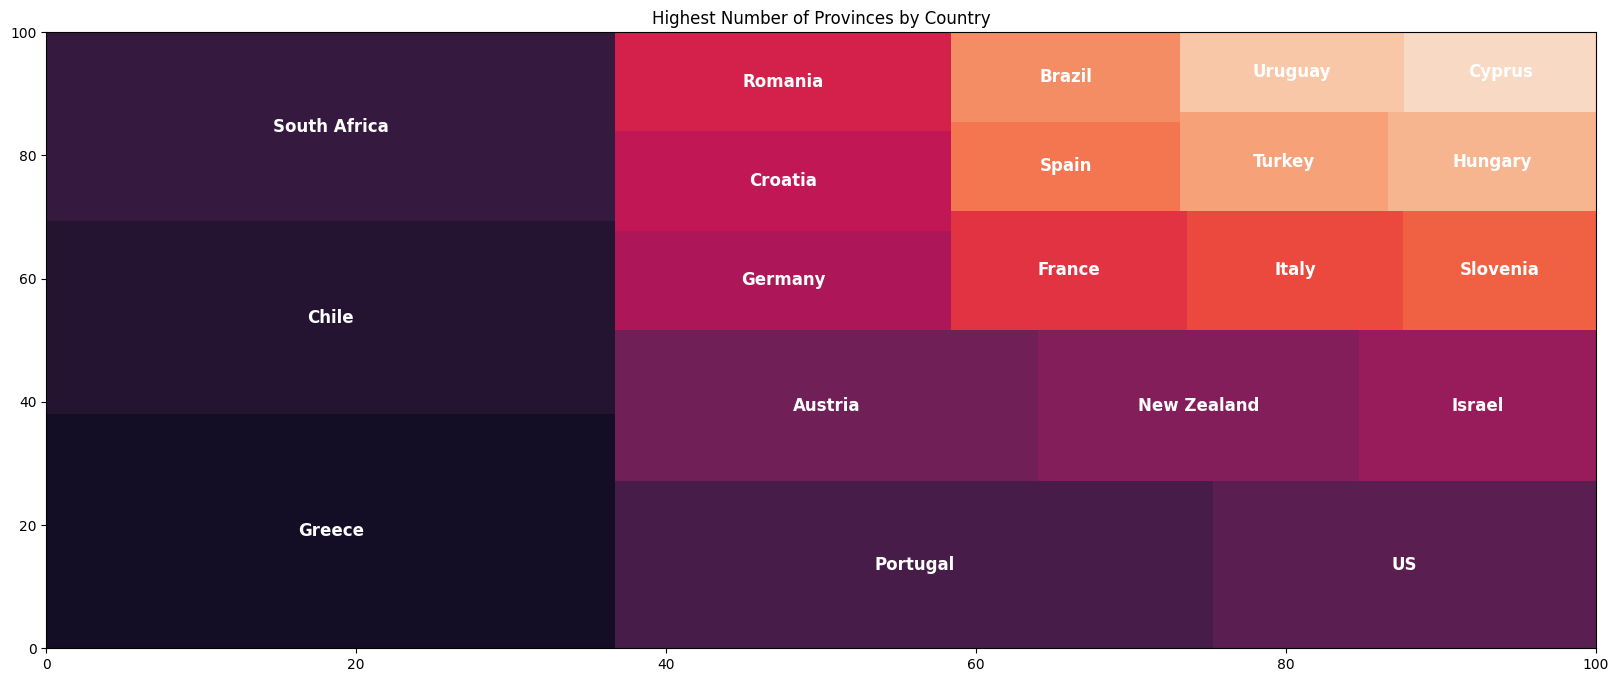

In [84]:
# Plot a treemap visualizing the top 20 countries with the most provinces
import squarify
province = wine_list.groupby('country')['province'].nunique().to_frame().reset_index().sort_values('province', ascending=False)
province = province[:20]
plt.figure(figsize=(20,8))
squarify.plot(province['province'].fillna(0.1), color=sns.color_palette("rocket", len(
                         province['country'].value_counts())),label=province['country'], text_kwargs={'fontsize':12, 'weight':'bold', 'color':'white'})
plt.title('Highest Number of Provinces by Country')

plt.show();

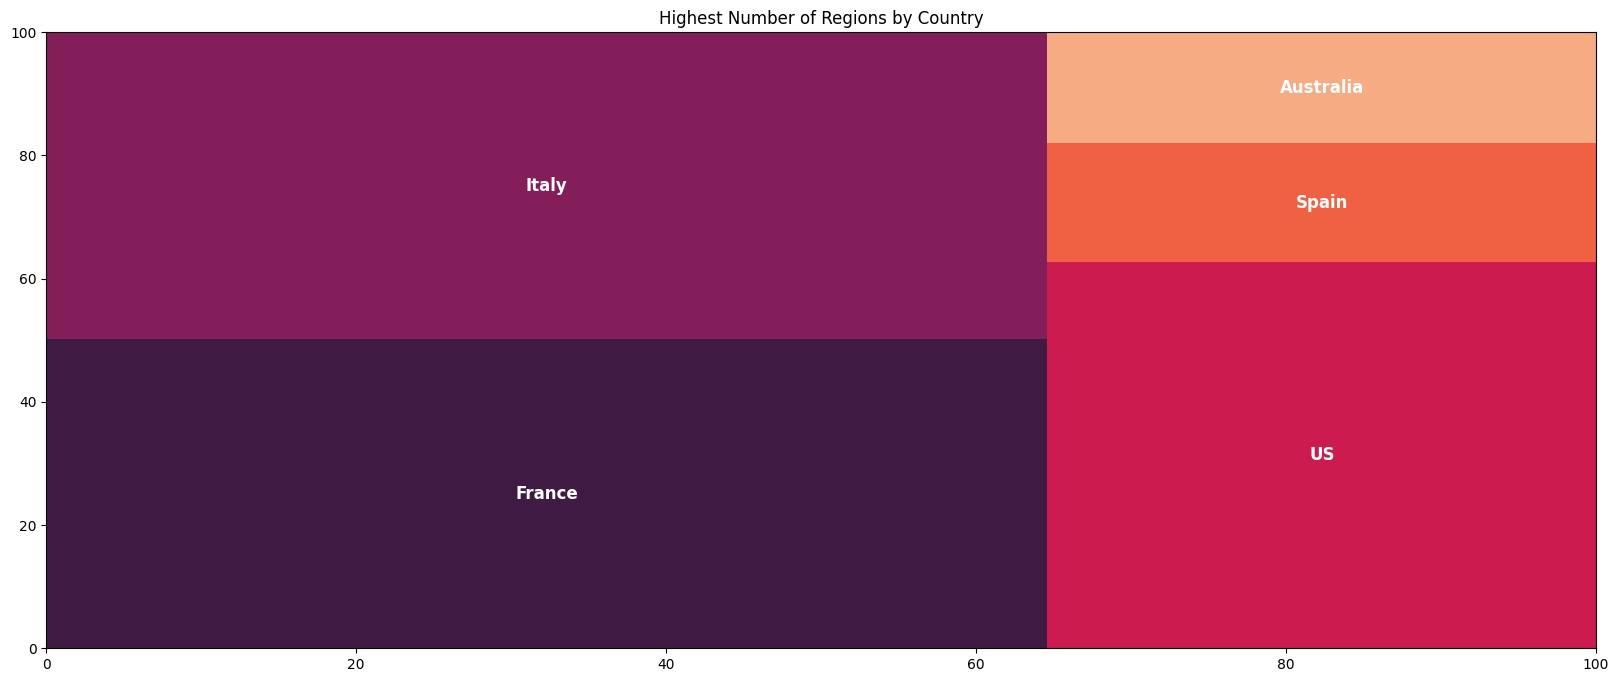

In [85]:
# Plot a treemap visualizing the top 5 countries with the most regions
region = wine_list.groupby('country')['region'].nunique().to_frame().reset_index().sort_values('region', ascending=False)
region = region[:5]
plt.figure(figsize=(20,8))
squarify.plot(region['region'].fillna(0.1), color=sns.color_palette("rocket", len(
                         region['country'].value_counts())),label=region['country'], text_kwargs={'fontsize':12, 'weight':'bold', 'color':'white'})
plt.title('Highest Number of Regions by Country')
plt.show();

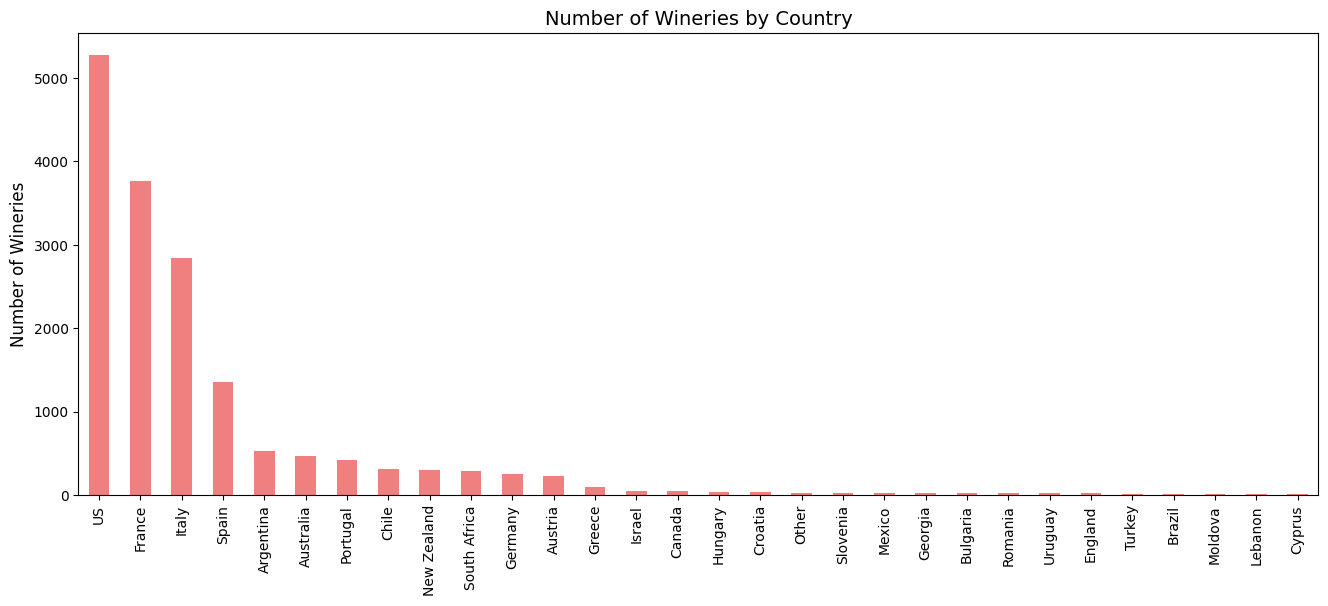

In [86]:
# Plot a barchart visualizing the countries with the wineries
wineries = wine_list.groupby('country')['winery'].nunique().to_frame().reset_index().sort_values('winery', ascending=False)
wineries[:30].plot(x='country', y='winery', kind='bar', legend=False, color = 'lightcoral', figsize=(16,6))
plt.title('Number of Wineries by Country', fontsize=14)
plt.xlabel('')
plt.ylabel('Number of Wineries', fontsize =12)
plt.show()

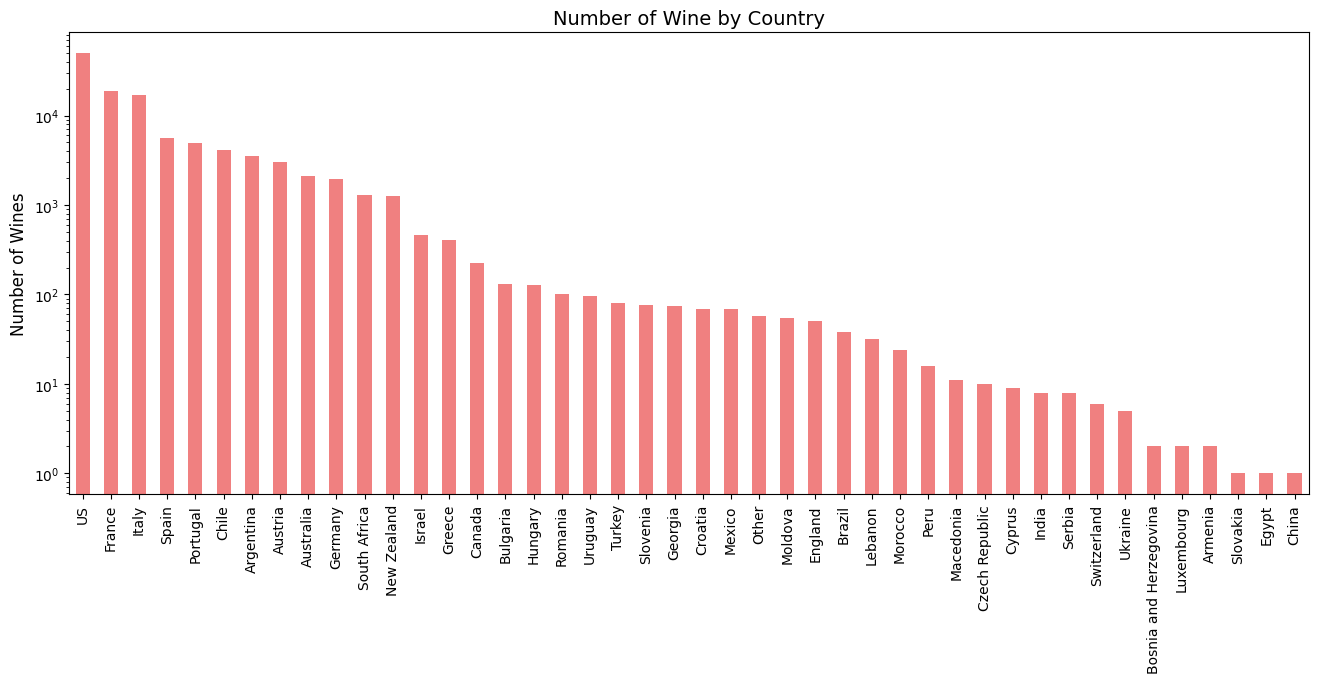

In [87]:
#plot number of wines in each country
country_wine = wine_list.groupby('country')['wine_name'].nunique().to_frame().reset_index().sort_values('wine_name', ascending=False)
country_wine.plot(x='country', y='wine_name', kind='bar', legend=False, color = 'lightcoral', figsize=(16,6))
plt.title('Number of Wine by Country', fontsize=14)
plt.xlabel('')
plt.ylabel('Number of Wines', fontsize =12)
plt.yscale('log')
plt.show()

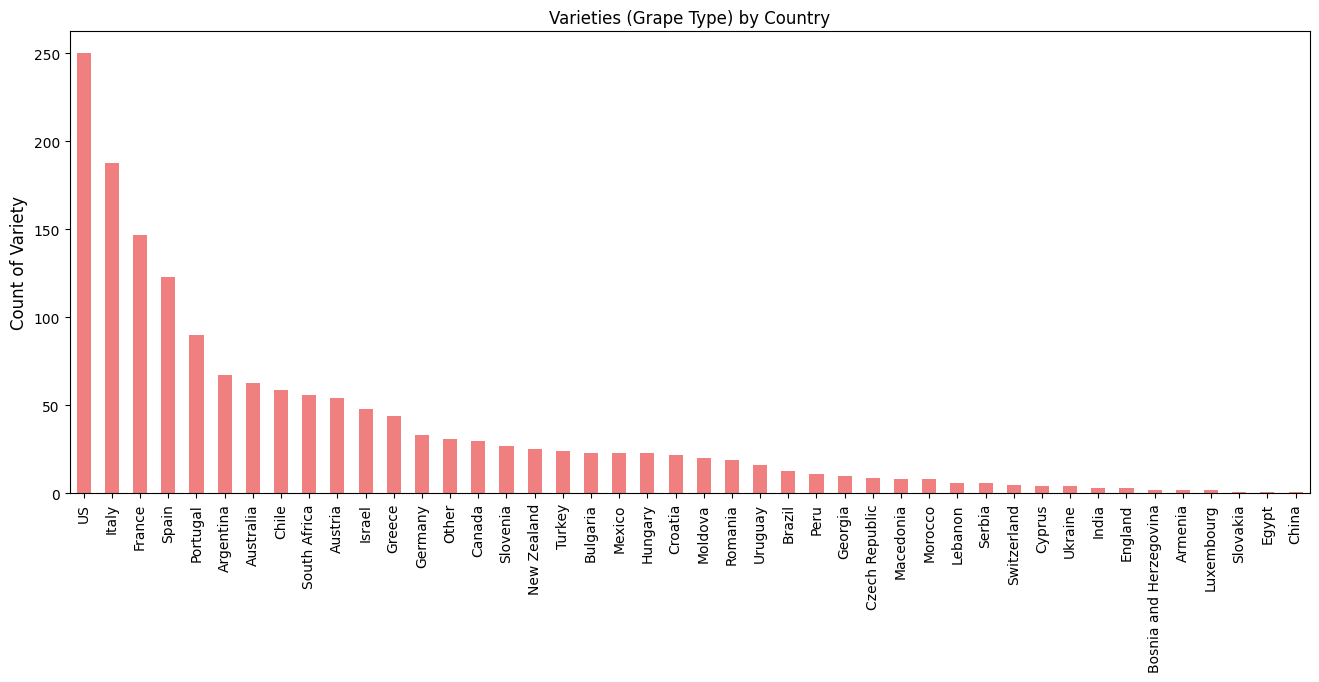

In [88]:
# Variety distribution of the countries
country_grape = wine_list.groupby('country')['variety'].nunique().to_frame().reset_index().sort_values( 'variety',ascending=False)
country_grape.plot(x='country', y='variety', kind='bar', legend=False, color = 'lightcoral', figsize=(16,6))
plt.title('Varieties (Grape Type) by Country')
plt.xlabel('')
plt.ylabel('Count of Variety', fontsize = 12)
plt.show();

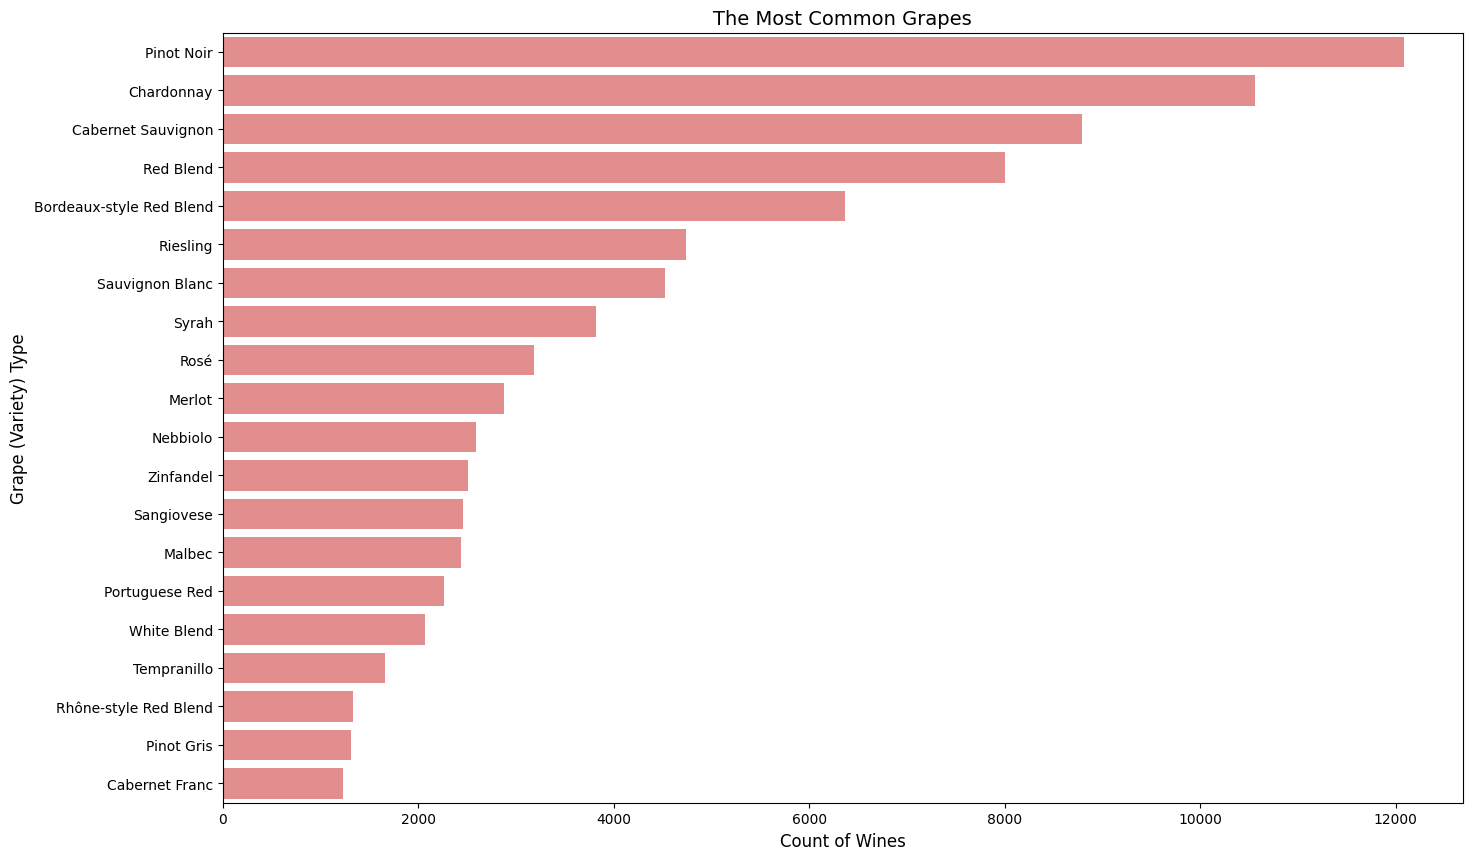

In [89]:
#most common grapes in all around the world
country_grape = wine_list.groupby('country')['variety'].value_counts().to_frame().reset_index().sort_values( 'variety',ascending=False)
common_grapes = country_grape.groupby('variety')['count'].sum().to_frame().reset_index().sort_values('count', ascending=False)
plt.figure(figsize=(16,10))
sns.barplot(x="count", y="variety", data=common_grapes[:20],
            label="Total", color="lightcoral")
plt.title('The Most Common Grapes', fontsize = 14)
plt.xlabel('Count of Wines', fontsize = 12)
plt.ylabel('Grape (Variety) Type', fontsize = 12)
plt.show();

/var/folders/2w/vhfbdjs16ws778lslztc15r00000gn/T/ipykernel_45066/627482167.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  color_bar = plt.colorbar(color_map)


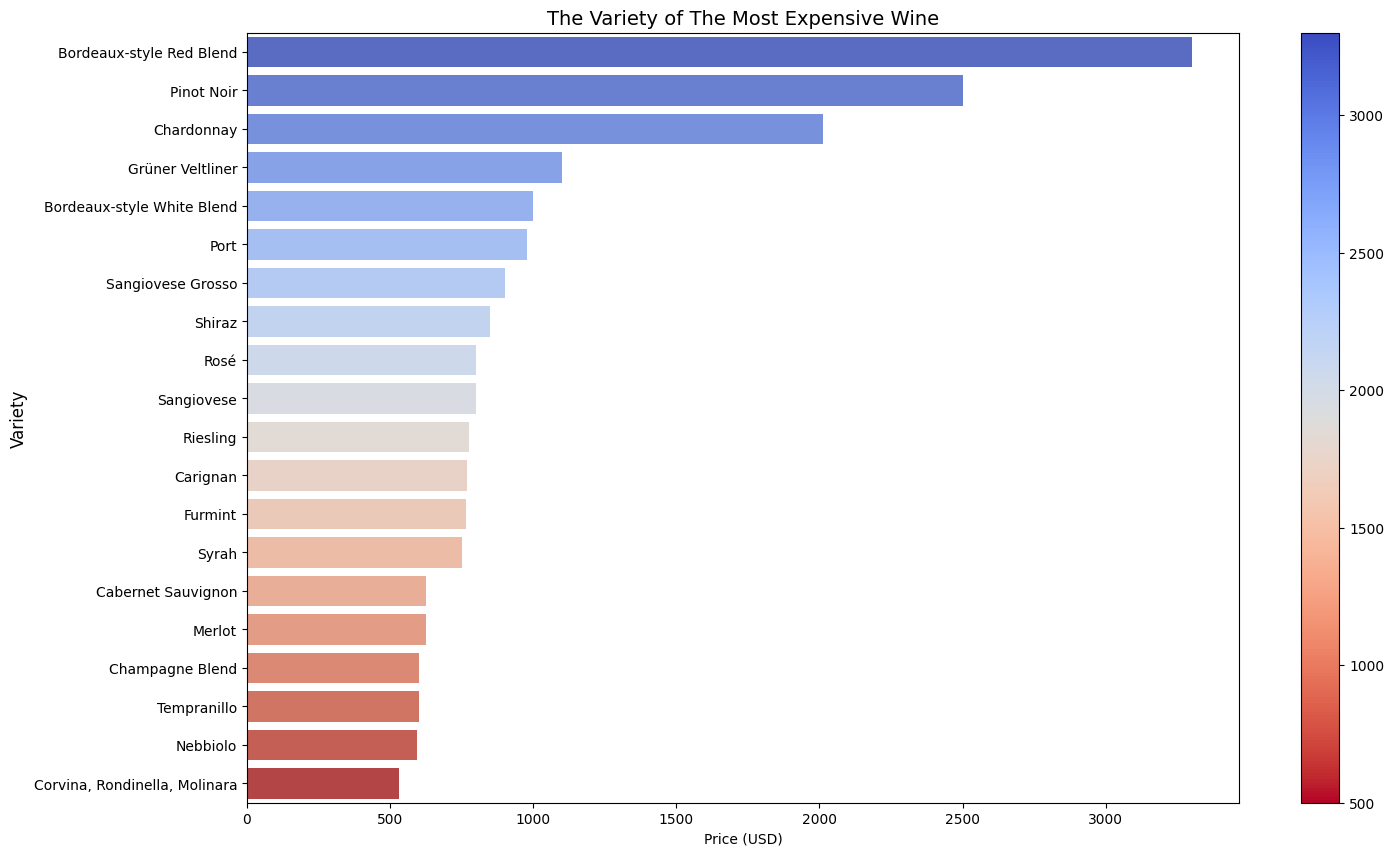

In [90]:
# variety of the top 20 most expensive wines
expensive_grapes = wine_list.groupby(['variety'])['price_USD'].max().sort_values(ascending=False).to_frame().reset_index()
plt.figure(figsize=(16,10))
sns.barplot(x="price_USD", y="variety", data=expensive_grapes[:20],label="Total", palette="coolwarm")
plt.title('The Variety of The Most Expensive Wine', fontsize = 14)
plt.ylabel('Variety', fontsize = 12)
cmin = 500
cmax = 3300
color_map = plt.cm.ScalarMappable(cmap='coolwarm_r')
color_map.set_array([])
color_map.set_clim(cmin, cmax)
color_bar = plt.colorbar(color_map)
plt.xlabel('Price (USD)');

/var/folders/2w/vhfbdjs16ws778lslztc15r00000gn/T/ipykernel_45066/43843976.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wine_list['price_USD'],color='lightcoral',ax=ax1)


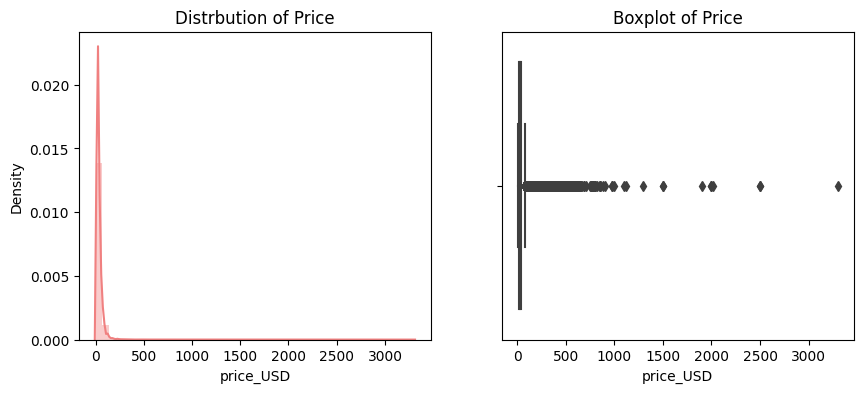

In [91]:
# price distribution and checking outliers
f, ax = plt.subplots(1,2,figsize=(10,4))
ax1,ax2 = ax.flatten()
sns.distplot(wine_list['price_USD'],color='lightcoral',ax=ax1)
ax1.set_title('Distrbution of Price')
sns.boxplot(x = wine_list['price_USD'], ax=ax2)
ax2.set_ylabel('')
ax2.set_title('Boxplot of Price');

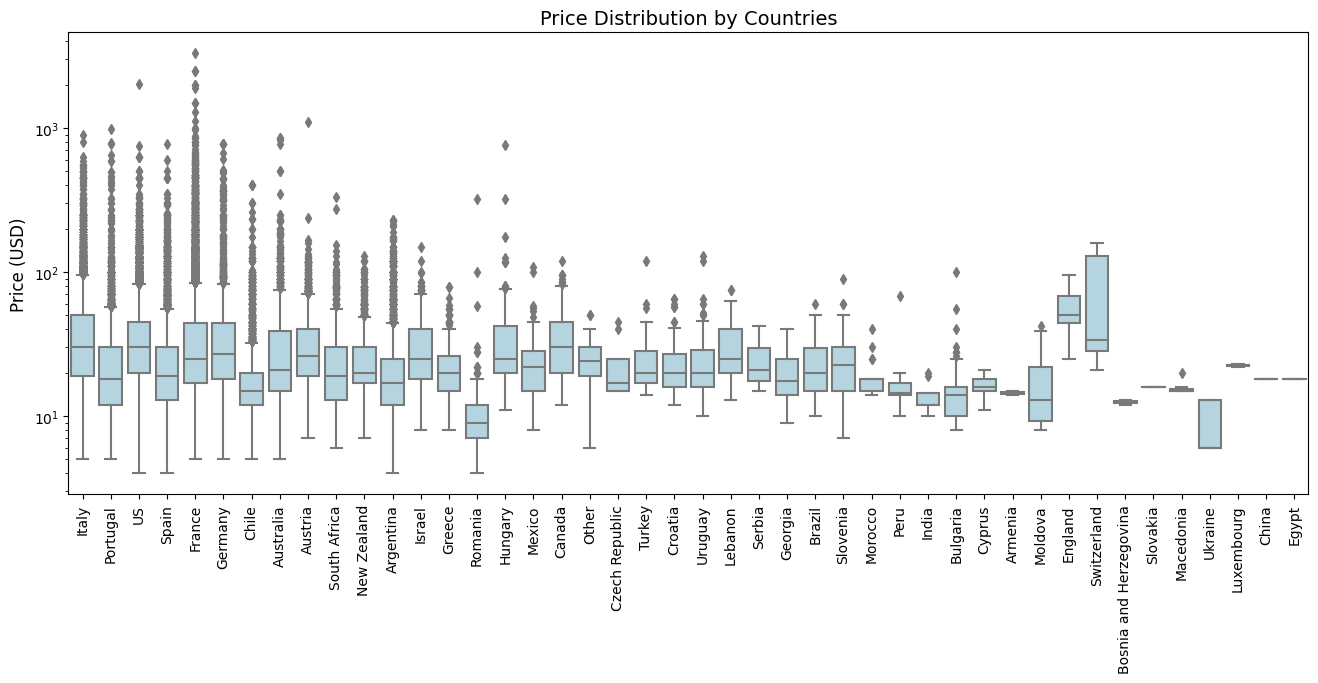

In [92]:
# Visulization of price of wines by countries
plt.figure(figsize=(16,6))
sns.boxplot(x = wine_list['country'], y = wine_list['price_USD'], color='lightblue')
plt.yscale("log")
plt.title('Price Distribution by Countries', fontsize = 14)
plt.ylabel('Price (USD)', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=90);

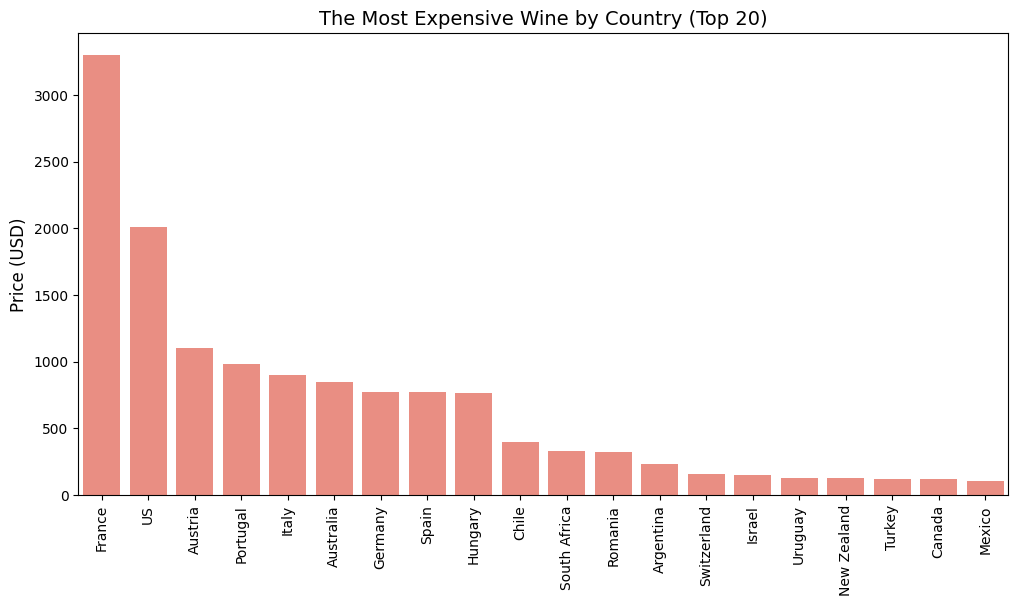

In [93]:
# the top 20 most expensive wine by country
max_price = wine_list.groupby('country')['price_USD'].max().to_frame().reset_index().sort_values('price_USD', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(data=max_price[:20], y="price_USD", x="country", color="salmon")
plt.title('The Most Expensive Wine by Country (Top 20)', fontsize = 14)
plt.xlabel('')
plt.ylabel('Price (USD)', fontsize = 12)
plt.xticks(rotation=90);

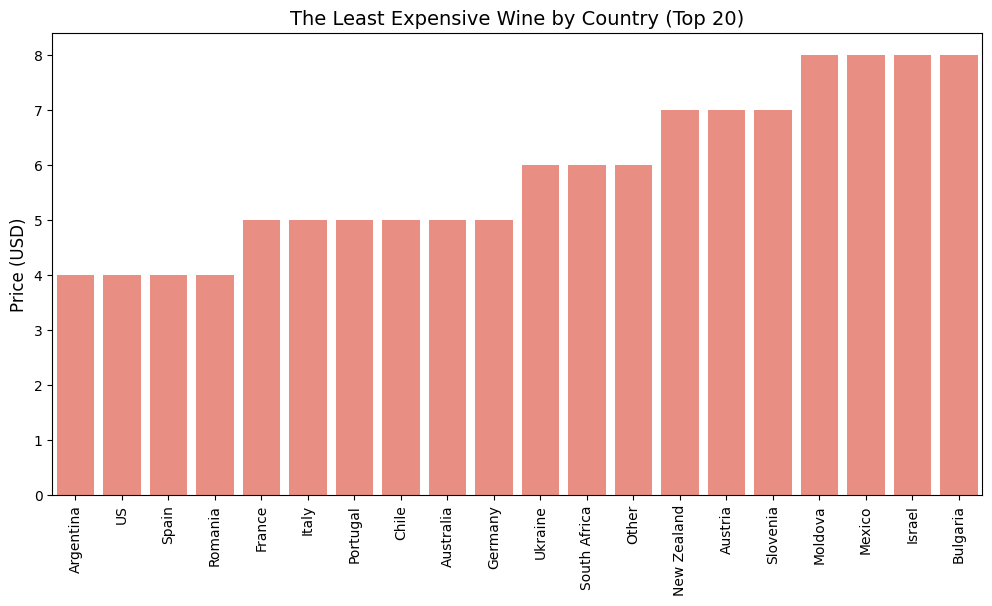

In [94]:
# the top 20 cheapest wine by country
min_price = wine_list.groupby('country')['price_USD'].min().to_frame().reset_index().sort_values('price_USD', ascending=True)
plt.figure(figsize=(12,6))
sns.barplot(data=min_price[:20], y="price_USD", x="country", color="salmon")
plt.title('The Least Expensive Wine by Country (Top 20)', fontsize = 14)
plt.xlabel('')
plt.ylabel('Price (USD)', fontsize = 12)
plt.xticks(rotation=90);

/var/folders/2w/vhfbdjs16ws778lslztc15r00000gn/T/ipykernel_45066/2577552101.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  color_bar = plt.colorbar(color_map)


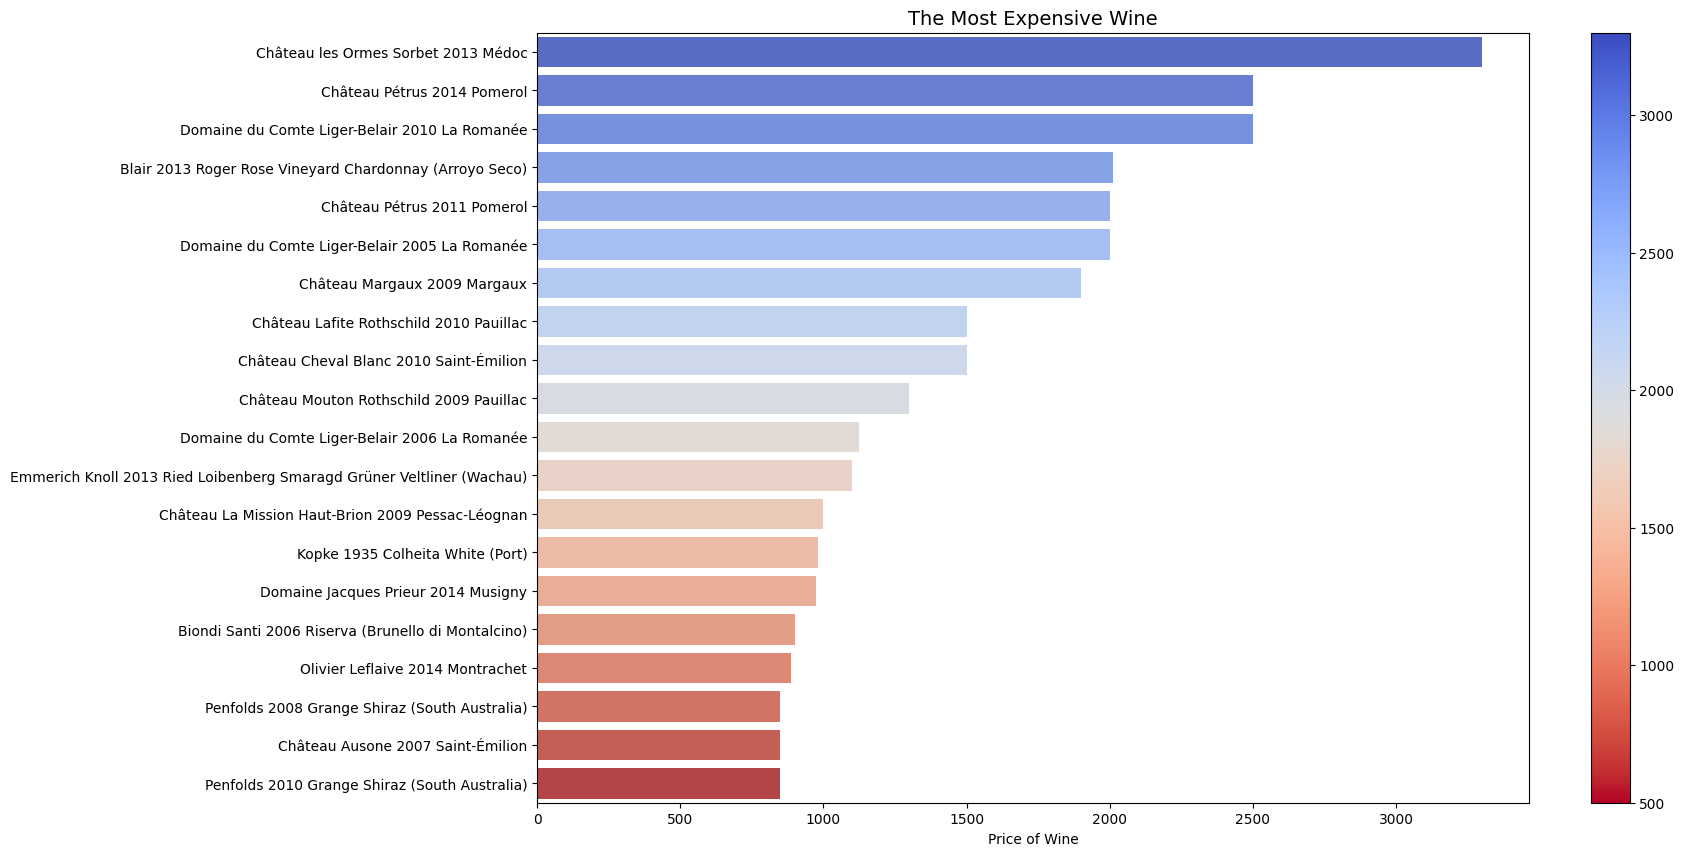

In [104]:
# visualizing the name of the top 20 most expensive wines
expensive_wines = wine_list.groupby(['wine_name'])['price_USD'].max().sort_values(ascending=False).to_frame().reset_index()
plt.figure(figsize=(16,10))
sns.barplot(x="price_USD", y="wine_name", data=expensive_wines[:20],label="Total", palette="coolwarm")
plt.title('The Most Expensive Wine', fontsize = 14)
plt.ylabel('', fontsize = 12)
cmin = 500
cmax = 3300
color_map = plt.cm.ScalarMappable(cmap='coolwarm_r')
color_map.set_array([])
color_map.set_clim(cmin, cmax)
color_bar = plt.colorbar(color_map)
plt.xlabel('Price of Wine');

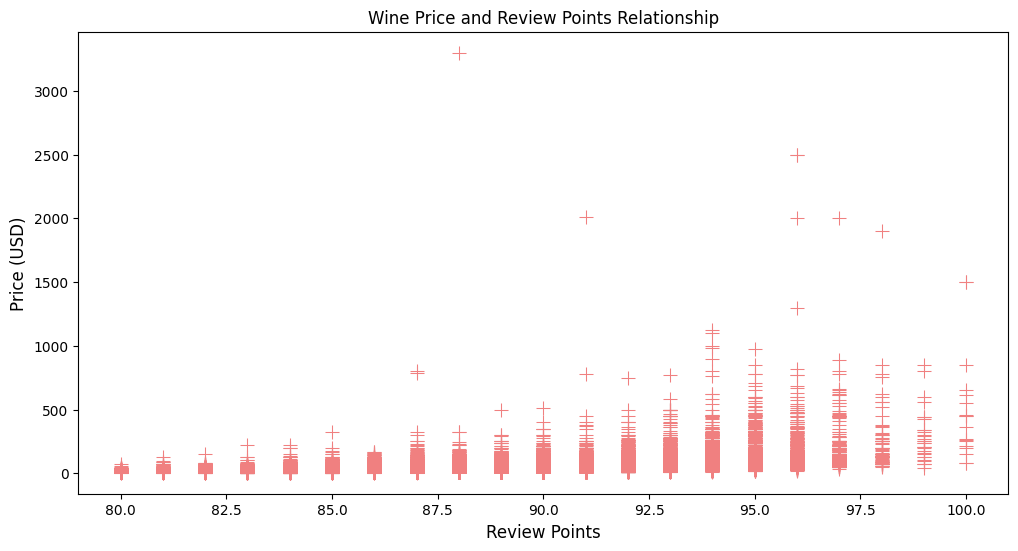

In [96]:
# Price and Points(Review Ratings) Relationship
plt.figure(figsize=(12,6))
sns.scatterplot(data=wine_list, x='points', y='price_USD',s=90, color="lightcoral", marker="+")
plt.title('Wine Price and Review Points Relationship', fontsize = 12)
plt.xlabel ('Review Points', fontsize=12)
plt.ylabel ('Price (USD)', fontsize=12)
plt.show()

In [97]:
# summary table of maximum values
summary_expensive = wine_list.groupby(['country','province','winery', 'variety'])['price_USD'].agg(
    ['count','min','max','mean']).sort_values(by = 'max',ascending = False)[:20]
summary_expensive.reset_index(inplace = True)
summary_expensive.style.highlight_max(color='red')

,country,province,winery,variety,count,min,max,mean
0,France,Bordeaux,Château les Ormes Sorbet,Bordeaux-style Red Blend,3,20,3300,1120.000000
1,France,Burgundy,Domaine du Comte Liger-Belair,Pinot Noir,8,30,2500,777.875000
2,France,Bordeaux,Château Pétrus,Bordeaux-style Red Blend,3,224,2500,1574.666667
3,US,California,Blair,Chardonnay,4,28,2013,532.750000
4,France,Bordeaux,Château Margaux,Bordeaux-style Red Blend,20,25,1900,260.850000
5,France,Bordeaux,Château Lafite Rothschild,Bordeaux-style Red Blend,18,36,1500,258.833333
6,France,Bordeaux,Château Cheval Blanc,Bordeaux-style Red Blend,11,30,1500,276.272727
7,France,Bordeaux,Château Mouton Rothschild,Bordeaux-style Red Blend,17,33,1300,276.411765
8,Austria,Wachau,Emmerich Knoll,Grüner Veltliner,18,25,1100,108.833333
9,France,Bordeaux,Château La Mission Haut-Brion,Bordeaux-style White Blend,2,767,1000,883.500000


### Data transfer to MYSQL 

In [98]:
#numberizing country, province, variety, winery and wine to create primary and foreign keys in MYSQL

wine_list['province_id'] = pd.factorize(wine_list['province'])[0] + 1
wine_list['variety_id'] = pd.factorize(wine_list['variety'])[0] + 1
wine_list['wine_id'] = pd.factorize(wine_list['wine_name'])[0] + 1
wine_list['country_id'] = pd.factorize(wine_list['country'])[0] + 1
wine_list['winery_id'] = pd.factorize(wine_list['winery'])[0] + 1

In [99]:
#creating sub-dataframe for SQL part
country_data = wine_list[['country','country_id']].drop_duplicates().reset_index(drop=True)
province_data = wine_list[['province_id', 'province', 'country_id']].drop_duplicates().reset_index(drop=True)
winery_data = wine_list[['winery_id', 'winery']].drop_duplicates().reset_index(drop=True)
wine_data = wine_list[['wine_id', 'wine_name','variety_id', 'province_id','points', 'price_USD','description', 'region', 'winery_id' ]].drop_duplicates().reset_index(drop=True)
variety_data = wine_list[['variety_id','variety']].drop_duplicates().reset_index(drop=True)

In [100]:
#sending data to mysql

import pymysql.cursors
from sqlalchemy import create_engine
from sqlalchemy import text

In [101]:
import getpass
sql_pass = getpass.getpass()

In [102]:
connection_string = 'mysql+pymysql://root:' + sql_pass + '@localhost:3306/'
engine = create_engine(connection_string)

In [103]:
country_data.to_sql('country_data', engine, 'wine_database', if_exists='replace', index=True)
province_data.to_sql('province_data', engine, 'wine_database', if_exists='replace', index=True)
winery_data.to_sql('winery_data', engine, 'wine_database', if_exists='replace', index=True)
wine_data.to_sql('wine_data', engine, 'wine_database', if_exists='replace', index=True)
variety_data.to_sql('variety_data', engine, 'wine_database', if_exists='replace', index=True)

OperationalError: (pymysql.err.OperationalError) (1045, "Access denied for user 'root'@'localhost' (using password: NO)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
wine_list

,country,description,points,price_USD,province,region,wine_name,variety,winery,year,country_id
0,Italy,"Aromas include tropical fruit, broom, brimston...",87.0,17,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87.0,15,Douro,Unknown,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,2
2,US,"Tart and snappy, the flavors of lime flesh and...",87.0,14,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,3
3,US,"Pineapple rind, lemon pith and orange blossom ...",87.0,13,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,3
4,US,"Much like the regular bottling from 2012, this...",87.0,65,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,3
...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90.0,28,Mosel,Unknown,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2013,6
129967,US,Citation is given as much as a decade of bottl...,90.0,75,Oregon,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2004,3
129968,France,Well-drained gravel soil gives this wine its c...,90.0,30,Alsace,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2013,5
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90.0,32,Alsace,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2012,5


### Paired wine & cheese dataframe

In [ ]:
# Create wine_cheese paired data
cheese_pairing_data = pd.DataFrame({'wine_name' :["Domaine des Lambrays 2005 Clos de Lambrays",
"Krug 2002 Brut (Champagne)", 
"Domaine Leflaive 2010 Bâtard-Montrachet",
"Jean-Michel Dupré 2015 1935 Vieilles Vignes (Morgon)",
"Artner 2012 Steinäcker Zweigelt (Carnuntum)",
"Robert Biale 2014 Limerick Lane Vineyard Zinfandel (Russian River Valley)",
"Bisol 2007 Cartizze (Prosecco Superiore di Cartizze)",
"Domaine Zind-Humbrecht 2012 Clos Saint Urbain Rangen de Thann Grand Cru Gewurztraminer (Alsace)",
"Bodegas Roda 2009 Cirsion (Rioja)",
"Pittacum 2012 La Prohibición Garnacha Tintorera (Vino de la Tierra de Castilla y León)",
"Bodega del Abad 2011 Carracedo Mencía (Bierzo)",
"Domaine Vacheron 2014 L'Enclos des Remparts Sauvignon Blanc (Vin de France)",
"Domaine Huët 2009 Clos du Bourg Première Trie Moelleux (Vouvray)",
"Schloss Gobelsburg 2015 Eiswein Grüner Veltliner (Niederösterreich)",
"Alpha Omega 2012 Stagecoach Vineyard Cabernet Sauvignon (Atlas Peak)",
"François Lurton 2011 Alka Carmenère (Colchagua Valley)",
"Masciarelli 2005 Villa Gemma (Montepulciano d'Abruzzo)",
"Château Vignelaure 2016 Rosé (Coteaux d'Aix-en-Provence)",
"Pietradolce 2016 Rosato (Etna)",
"Müller-Catoir 2007 Breumel in den Mauren Trockenbeerenauslese Riesling (Pfalz)",
"Château La Nerthe 2012 Clos de Beauvenir White (Châteauneuf-du-Pape)",
"Capichera 2013 VT Vermentino (Isola dei Nuraghi)",
"Bucci 2013 Villa Bucci Riserva (Verdicchio dei Castelli di Jesi Classico Superiore)",
"Château du Cèdre 2012 GC Malbec (Cahors)",
"Penfolds 2008 Grange Shiraz (South Australia)",
"Bodegas Gutiérrez de la Vega 1999 Casta Diva Fondillón Sweet Monastrell (Alicante)",
"Krutzler 2012 Perwolff Blaufränkisch (Südburgenland)",
"Château Pontet-Canet 2009 Barrel sample (Pauillac)",
"Tenuta dell'Ornellaia 2007 Masseto Merlot (Toscana)"],

'cheese': ["Gruyère", "Brie", "Camambert", "Cheshire", "Emmental", "Roquefort","Asiago", "Munster","Idiazabal", "Zamorano",
                         "Roncal", "Chèvre", "Bûcheron", "Florette", "Aged Cheddar", "Smoked Gouda", "Parmigiano-Reggiano", "Havarti", "Ricotta",
                         "Raclette", "Mild Cheddar", "Fiore Sardo", "Requesón", "Edam", "Gouda", "Tomme", "Abbaye de Belloc", "Comté","Manchego"]}) 

### Sending data to CSV

In [ ]:
### Save the clean dataset as a CSV.

wine_list.to_csv('clean_dataset.csv', index=False)
cheese_pairing_data.to_csv('paired_cheese_wine_data.csv', index = False)